## use autokeras to learn cell fractions from gene expression

#### imports and notebook variables

In [1]:
import pandas as pd
import random
import autokeras as ak
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# parameters
# naming
cohort = 'ppmi'
# expr_name = 'enriched'
# expr_name = 'enhanced'
expr_name = 'specific'
overwrite_model = False
add_random = False

In [3]:
# Parameters
cohort = "ppmi"
expr_name = "enriched"
overwrite_model = True
add_random = False


In [4]:
# naming
visit_months = {'BL':0, 'V02':6, 'V04':12, 'V06':24, 'V08':36}
visit_names = {'BL':'BLM0T1', 'V02':'SVM6T1', 'V04':'SVM12T1', 'V06':'SVM24T1', 'V08':'SVM36T1'}
cell_types = ['Basophils', 'Eosinophils', 'Lymphocytes', 'Monocytes', 'Neutrophils']

# in bucket data
expr_bckt_file = f'gs://nihnialngcbg-eqtl/amppd/salmon/quantification/{cohort}.wb.norm.hdf5'
fracs_bckt_file = f'gs://nihnialngcbg-eqtl/amppd/clinical/{cohort}.bld_chem_fractions.csv'
cell_genes_bckt_file = f'gs://nihnialngcbg-eqtl/amppd/salmon/quantification/blood_cell_lineage_{expr_name}_genes.csv'
# gencode_bckt_file = 'gs://nihnialngcbg-eqtl/amppd/salmon/quantification/gencode.v29.primary_assembly.annotation.pkl'

# local files
expr_file = f'{cohort}.wb.norm.hdf5'
fracs_file = f'{cohort}.bld_chem_fractions.csv'
cell_genes_enriched_file = 'blood_cell_lineage_genes.csv'
# gencode_pkl = 'gencode.v29.primary_assembly.annotation.pkl'
model_file = f'{cohort}.{expr_name}.model.cellfracs.h5'
predicted_fractions_for_missing_file = f'{cohort}.{expr_name}.predicted.bld_chem_fractions.csv'
tboard_log_dir = f'./tb_{expr_name}_logs'
train_test_file = f'{cohort}.{expr_name}.features_targets.csv'

capture_out = !(nproc)
max_threads = int(capture_out[0])

#### pull src data local

In [5]:
!gsutil -mq cp {expr_bckt_file} {expr_file}
!gsutil -mq cp {fracs_bckt_file} {fracs_file}
!gsutil -mq cp {cell_genes_bckt_file} {cell_genes_enriched_file}
# !gsutil -mq cp {gencode_bckt_file} {gencode_pkl}

#### load the expression data subset for enriched genes

In [6]:
expr_df = pd.read_hdf(expr_file)
print(f'all expr data {expr_df.shape}')
enriched_genes = pd.read_csv(cell_genes_enriched_file)
print(f'all enriched genes {enriched_genes.shape}')
gene_id_to_keep = set(enriched_genes['gene_id']) & set(expr_df.columns)
print(f'found {len(gene_id_to_keep)} of enriched genes in expression data')
if add_random:
#     quants_vars = expr_df.var()
#     gene_id_to_keep = gene_id_to_keep | set(quants_vars.sort_values(ascending=False).head(len(gene_id_to_keep)).index)
#     print(f'found {len(gene_id_to_keep)} of enriched genes plus high variance in expression data')
    gene_id_to_keep = gene_id_to_keep | set(random.sample(list(expr_df.columns.values), 
                                                          len(gene_id_to_keep)))
    print(f'found {len(gene_id_to_keep)} of enriched genes plus random in expression data')
expr_df = expr_df[list(gene_id_to_keep)]
print(f'all enriched expr data {expr_df.shape}')

all expr data (4610, 16782)
all enriched genes (516, 2)
found 310 of enriched genes in expression data
all enriched expr data (4610, 310)


#### load the cell fractions data

In [7]:
fracs_df = pd.read_csv(fracs_file)
print(fracs_df.shape)

(5035, 7)


In [8]:
# set the rna IDs to the match the IDs in the expression matrix
for visit_number, visit_name in visit_names.items():
    fracs_df.loc[fracs_df['visit'] == visit_number, 'rnaid'] = fracs_df['id'] + '-' + visit_name 

# drop the samples where a rnaid wasn't set, ie nans
fracs_df.dropna(subset=['rnaid'], inplace=True)
# set this new id as the index
fracs_df.set_index('rnaid', drop=True, inplace=True)
# and then drop original id and visit
fracs_df.drop(columns=['id', 'visit'], inplace=True)    
print(fracs_df.shape)

(2387, 5)


In [9]:
# check cell type summaries
fracs_df.describe()

,Basophils,Eosinophils,Lymphocytes,Monocytes,Neutrophils
count,2387.000000,2387.000000,2387.000000,2387.000000,2387.000000
mean,0.642648,2.392333,28.050021,6.379933,62.535023
std,0.340675,1.597931,7.397466,1.714341,7.934574
min,0.000000,0.000000,5.500000,1.000000,25.000000
25%,0.400000,1.400000,22.900000,5.300000,57.300000
50%,0.600000,2.000000,27.800000,6.200000,62.600000
75%,0.800000,3.000000,32.800000,7.300000,68.000000
max,3.200000,16.400000,69.000000,15.700000,91.400000


#### merge expr data and cell fraction data

In [10]:
data_df = expr_df.merge(fracs_df, how='inner', left_index=True, right_index=True)
print(data_df.shape)

(1804, 315)


#### save the feature/target data set

In [11]:
data_df.to_csv(train_test_file)

#### prep the test and train split

In [12]:
features, targets = data_df.drop(columns=cell_types), data_df[cell_types] #label encode the target
features_train, features_test, targets_train, targets_test = train_test_split(features, 
                                                                              targets, 
                                                                              test_size=0.3)
print(features_train.shape, features_test.shape, targets_train.shape, targets_test.shape)

(1262, 310) (542, 310) (1262, 5) (542, 5)


#### setup the tensorboard callback

In [13]:
tensorboard_callback = TensorBoard(log_dir=tboard_log_dir, histogram_freq=0, 
                                   write_graph=True, write_images=False)

#### search for the best model

In [14]:
%%time
# define the search
search = ak.StructuredDataRegressor(loss='mean_absolute_error', 
                                    project_name=f'sdr_{expr_name}',
                                    column_names=features_train.columns.to_list(),
                                    overwrite=overwrite_model,
                                    seed=42)
# perform the search
search.fit(x=features_train, y=targets_train, verbose=0, callbacks=[tensorboard_callback])

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


INFO:tensorflow:Oracle triggered exit


CPU times: user 2h 10min 7s, sys: 40min 32s, total: 2h 50min 39s
Wall time: 54min 5s


In [15]:
# evaluate the model
mae, mse = search.evaluate(features_test, targets_test, verbose=0)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

MAE: 1.342
MSE: 4.995


In [16]:
# get the best performing model
model = search.export_model()
# summarize the loaded model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 310)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 310)               0         
_________________________________________________________________
normalization (Normalization (None, 310)               621       
_________________________________________________________________
dense (Dense)                (None, 32)                9952      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)               

In [17]:
# save the best performing model to file
model.save(model_file)

#### see sklearn metrics

In [18]:
def print_sklearn_reg_metrics(test_actual, test_predicted):
    sk_metrics = r2_score(test_actual, test_predicted, multioutput='raw_values')
    print(f'r2_score, raw_values: {sk_metrics}')
    sk_metrics = mean_squared_error(test_actual, test_predicted, multioutput='raw_values')
    print(f'mean_squared_error, raw_values: {sk_metrics}')
    sk_metrics = mean_squared_error(test_actual, test_predicted, multioutput='uniform_average')
    print(f'mean_squared_error, uniform_average: {sk_metrics}')
    sk_metrics = mean_absolute_error(test_actual, test_predicted, multioutput='raw_values')
    print(f'mean_absolute_error, raw_values: {sk_metrics}')
    sk_metrics = mean_absolute_error(test_actual, test_predicted, multioutput='uniform_average')
    print(f'mean_absolute_error, uniform_average: {sk_metrics}')

print(cell_types)
features_test_predicted = search.predict(features_test)
print_sklearn_reg_metrics(targets_test, features_test_predicted)
features_train_predicted = search.predict(features_train)
print_sklearn_reg_metrics(targets_train, features_train_predicted)

['Basophils', 'Eosinophils', 'Lymphocytes', 'Monocytes', 'Neutrophils']


r2_score, raw_values: [-0.08892117  0.54886918  0.82856846  0.10158727  0.80199102]
mean_squared_error, raw_values: [ 0.14886806  1.25655927  8.80306964  2.77261334 11.99339469]
mean_squared_error, uniform_average: 4.994901001028518
mean_absolute_error, raw_values: [0.25215952 0.78265525 2.00873168 1.18637922 2.47799978]
mean_absolute_error, uniform_average: 1.341585090793806


r2_score, raw_values: [-0.17554515  0.52427975  0.85791729  0.16674452  0.84207461]
mean_squared_error, raw_values: [ 0.12806145  1.16247623  8.29344705  2.31558272 10.59301779]
mean_squared_error, uniform_average: 4.49851704900103
mean_absolute_error, raw_values: [0.25763279 0.76026373 1.86006138 1.09627983 2.21999854]
mean_absolute_error, uniform_average: 1.2388472523591028


#### check scores with cross fold validation

In [19]:
# n_scores = cross_val_score(model, features_train, targets_train, scoring='accuracy', cv=5, n_jobs=max_threads)
# print(n_scores)

#### plot the test comparisons

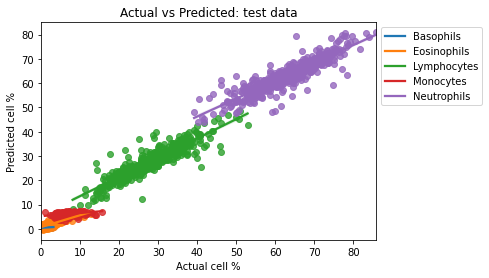

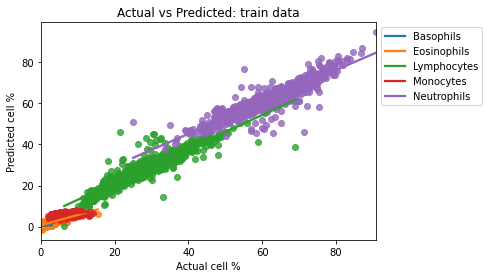

In [20]:
def plot_regressions(cell_types, actual_df, predicted_df, title):
    for index, celltype in enumerate(cell_types):
        sns.regplot(x=actual_df[celltype], y=predicted_df[:,index])
    plt.xlabel('Actual cell %')
    plt.ylabel('Predicted cell %')
    plt.title(f'Actual vs Predicted: {title}')
    plt.legend(cell_types, bbox_to_anchor=(1, 1))
    plt.show()
    
plot_regressions(cell_types, targets_test, features_test_predicted, 'test data')
plot_regressions(cell_types, targets_train, features_train_predicted, 'train data')

#### plot the model

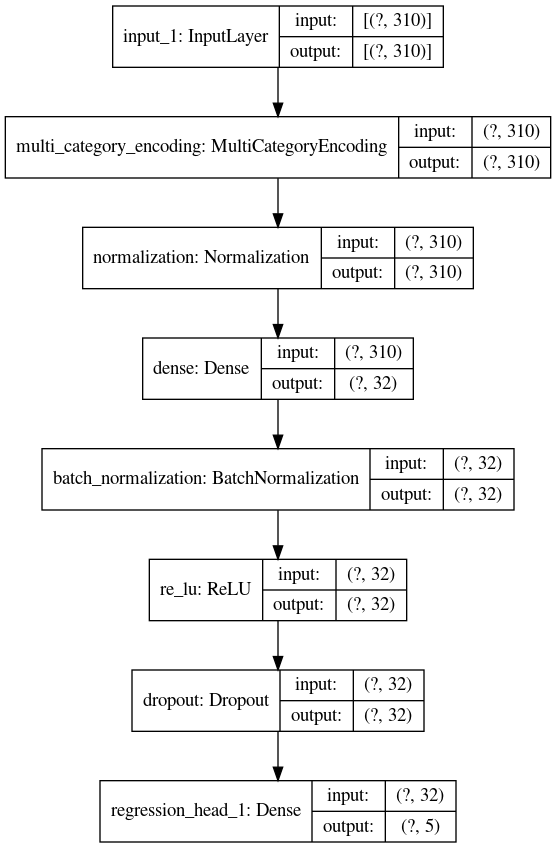

In [21]:
import keras
keras.utils.plot_model(model, f'{expr_name}_model_with_shape_info.png', show_shapes=True)


#### now predict fractions for samples that don't have them

In [22]:
missing_fracs_expr_df = expr_df.loc[~expr_df.index.isin(data_df.index)]
print(missing_fracs_expr_df.shape)

(2806, 310)


In [23]:
missing_predicted = search.predict(missing_fracs_expr_df)

In [24]:
missing_predicted_df = pd.DataFrame(data=missing_predicted, columns=cell_types, 
                                 index=missing_fracs_expr_df.index)
missing_predicted_df.index.name = 'rnaid'
missing_predicted_df.to_csv(predicted_fractions_for_missing_file)

In [25]:
missing_predicted_df.mean(axis=0)

Basophils       0.499751
Eosinophils     1.906828
Lymphocytes    28.251642
Monocytes       6.029589
Neutrophils    62.393082
dtype: float32

In [26]:
targets_train.mean(axis=0)

Basophils       0.646513
Eosinophils     2.430190
Lymphocytes    28.066719
Monocytes       6.381458
Neutrophils    62.473376
dtype: float64

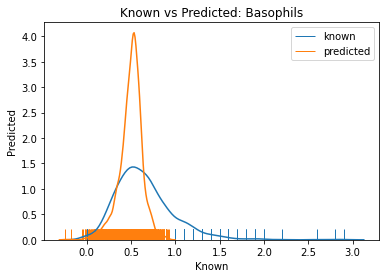

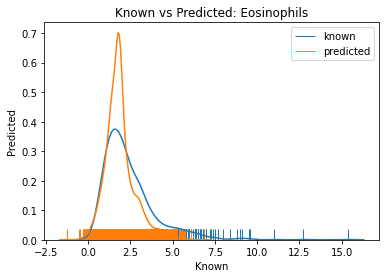

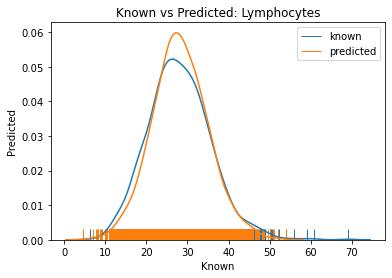

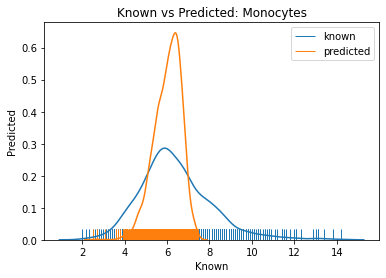

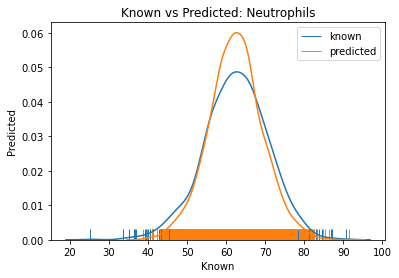

In [27]:
def plot_densities(cell_types, known_df, predicted_df):
    for index, celltype in enumerate(cell_types):
        sns.distplot(known_df[celltype], rug=True, hist=False)
        sns.distplot(predicted_df[celltype], rug=True, hist=False)
        plt.xlabel('Known')
        plt.ylabel('Predicted')
        plt.title(f'Known vs Predicted: {celltype}')
        plt.legend(['known', 'predicted'], bbox_to_anchor=(1, 1))
        plt.show()
    
plot_densities(cell_types, targets_train, missing_predicted_df)